<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk
!pip install nxviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 3.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import collections
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import itertools
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import networkx as nx
import nxviz as nv
from nxviz import annotate

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.10/dist-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk

True

In [3]:
def month_to_number(month):
  months = {"january": "1", "february": "2", "march": "3", "april": "4", "may": "5", "june": "6", "july": "7", \
            "august": "8", "september": "9", "october": "10", "november": "11", "december": "12"}
  month = month.lower()
  numerical = months[month]
  return numerical

def to_date(string):
  elements = string.split(',')
  year = elements[-1].strip()
  month, day = elements[-2].split()
  month = month_to_number(month)
  date = f'{year}-{month}-{day}'
  return date

In [4]:
def clean_df(df):
  df = pd.read_excel(df)
  df = df.fillna('n/a')
  df = df.drop(df[df['Mention of Adam smith'].str.contains('NA')].index)
  df = df.drop(df[df['Mention of Adam smith'].str.contains('n/a')].index)
  df.columns = ['Date', 'Extract', 'Notes', 'Notes2', 'About Adam Smith', 'Rep']
  dates = []
  for index, row in df.iterrows():
    dates.append(to_date(row['Date']))
  df['Date'] = dates
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.set_index('Date').sort_index()
  return df
df = clean_df('https://github.com/yuliiabosher/Adam_Smith_project/raw/main/adam_smith.xlsx')
display(df.head())

,Extract,Notes,Notes2,About Adam Smith,Rep
Date,,,,,
2008-06-10,Democrats will claim this bill will bring gas ...,n/a,n/a,n/a,Mitch McConnell \nRepublican Party
2008-06-12,The sad truth is that the bulk of the EADS tan...,n/a,n/a,n/a,Donald Anthony Manzullo\nRepublican Party
2008-07-10,"The father of modern capitalism, Adam Smith, o...",n/a,n/a,n/a,Joseph Isadore Lieberman\nDemocratic Party
2008-07-15,This gold is not coming back on the market. Su...,n/a,n/a,n/a,Steve King\nRepublican Party
2008-07-23,There are those who will object to the bill be...,n/a,n/a,-‘‘The Wealth of Nations”\n- Those exertions o...,Joseph Isadore Lieberman\nDemocratic Party


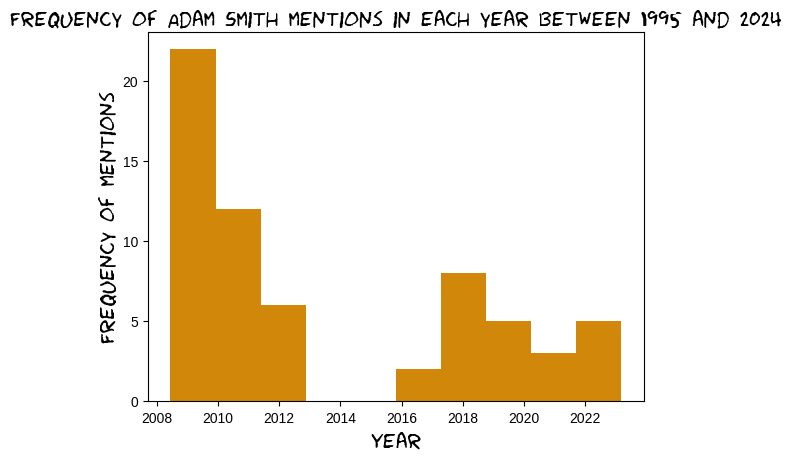

In [5]:
def create_histogram(df):
  #styles 'fast','fivethirtyeight'',',''seaborn-v0_8-whitegrid'
  fig, ax = plt.subplots()
  plt.style.use('seaborn-v0_8-whitegrid')
  plt.hist(df.index, color='#D1870A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.xlabel('Year', fontdict = font)
  plt.ylabel('Frequency of mentions', fontdict = font)
  plt.title('Frequency of Adam Smith mentions in each year between 1995 and 2024', fontdict = font)
  plt.show()

create_histogram(df)

In [6]:
def tokenize_df(df):
  tokens = [nltk.word_tokenize(row['Extract']) for index, row in df.iterrows()]
  return tokens

token_list = tokenize_df(df)
print(token_list[0][:10])

['Democrats', 'will', 'claim', 'this', 'bill', 'will', 'bring', 'gas', 'prices', 'down']


In [54]:
def preprocess_tokens(list_of_lists):
  lower_tokens = [[t.lower() for t in list_of_tokens] for list_of_tokens in list_of_lists for t in list_of_tokens]
  alpha_num_only = [[t for t in token_list if t.isalnum()] for token_list in lower_tokens]
  stopwords = nltk.corpus.stopwords.words('english')
  stopwords.extend(['adam', 'smith', 'get', 'like', 'said', 'go', 'going', 'would', 'mean', 'well', 'never', 'read', 'wrote', 'see', 'one'])
  no_stops = [[t for t in alpha_list if t not in stopwords] for alpha_list in alpha_num_only]
  wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
  lemmatized = [[wordnet_lemmatizer.lemmatize(t) for t in no_stops_list] for no_stops_list in no_stops]
  return lemmatized

preprocessed = preprocess_tokens(token_list)
print(preprocessed[0][:10])

['democrat', 'claim', 'bill', 'bring', 'gas', 'price', 'counting', 'american', 'forget', 'basic']


In [55]:
def create_corpus(preprocessed_data):
  dictionary = Dictionary(preprocessed)
  corpus = [dictionary.doc2bow(article) for article in preprocessed]
  return dictionary, corpus

dictionary, corpus = create_corpus(preprocessed)
print(corpus[0][:10])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [59]:
def find_most_frequently_occuring_pairs(corpus):
  word_id_list_of_lists = [[i[0] for i in j] for j in corpus]
  pair_list_of_lists = [list(itertools.combinations(nested_list,2)) for nested_list in word_id_list_of_lists]
  catalogue_of_occurences = collections.defaultdict(int)
  for list_of_pairs in pair_list_of_lists:
    for pair in list_of_pairs:
      catalogue_of_occurences[pair]+=1
  most_frequently_occuring_pairs = sorted(list(catalogue_of_occurences.items()), key=lambda x: x[1], reverse=True)
  return most_frequently_occuring_pairs
most_frequently_occuring_pairs = find_most_frequently_occuring_pairs(corpus)
print(most_frequently_occuring_pairs[:10])

[((46, 85), 1805), ((61, 69), 1233), ((46, 61), 1159), ((61, 85), 1106), ((85, 133), 951), ((46, 69), 882), ((69, 85), 853), ((61, 63), 761), ((164, 323), 759), ((61, 284), 742)]


In [64]:
for nested_tuple in most_frequently_occuring_pairs[:10]:
  print(dictionary.get(nested_tuple[0][0]), dictionary.get(nested_tuple[0][1]))

nation wealth
free market
nation free
free wealth
wealth 1776
nation market
market wealth
free government
hand invisible
free enterprise


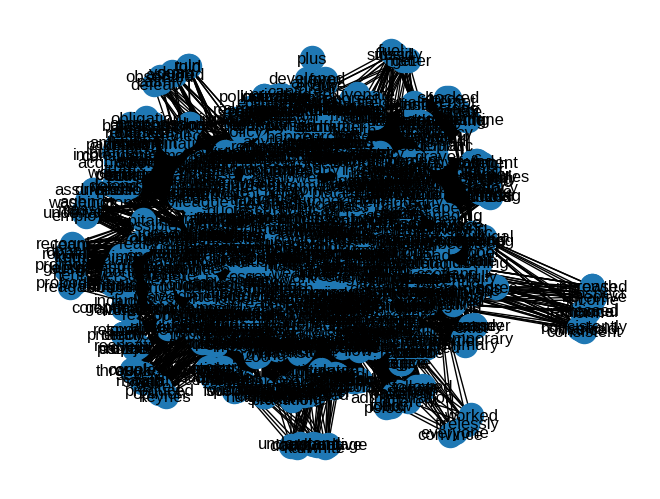

In [72]:
G = nx.Graph()
nodes = [i[0] for j in corpus for i in j]
G.add_nodes_from(nodes)
[G.add_edge(i[0][0],i[0][1]) for i in most_frequently_occuring_pairs]
for word_id in nodes:
  G.nodes[word_id]['label'] = dictionary.get(word_id)
labels = {}
for node, data in G.nodes(data=True):
  labels[node] = data.get('label')
nx.draw(G, with_labels=True, labels = labels)

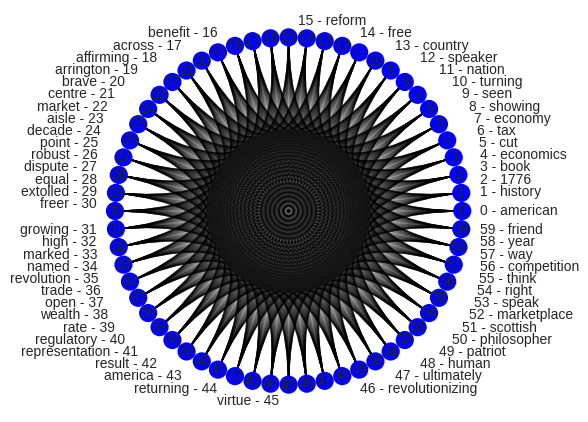

In [73]:
def visualise_clique(n):
  largest_clique = sorted(nx.find_cliques(G), key=lambda x:len(x))[n]
  G_lc = G.subgraph(largest_clique)
  c = nv.circos(G_lc)
  labels = {}
  for node, data in G_lc.nodes(data=True):
    labels[node] = data.get('label')
  G_lc = nx.relabel_nodes(G_lc, labels)
  annotate.circos_labels(G_lc,  layout="numbers")
  plt.tight_layout(rect=(0.05, 0.05, 0.95, 0.95))
  plt.show()
visualise_clique(-1)

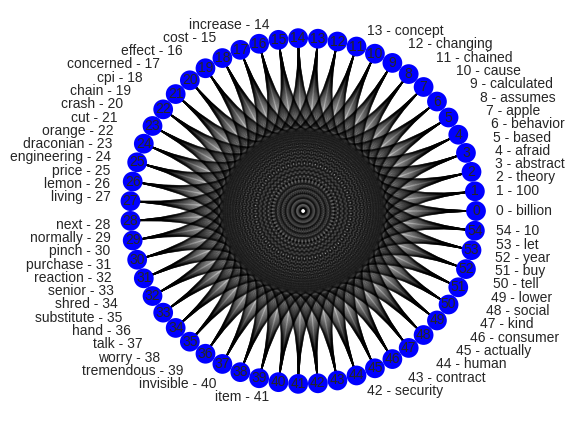

In [74]:
visualise_clique(-2)

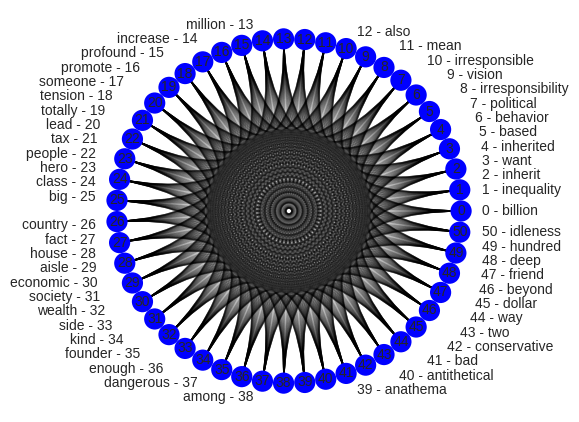

In [75]:
visualise_clique(-3)

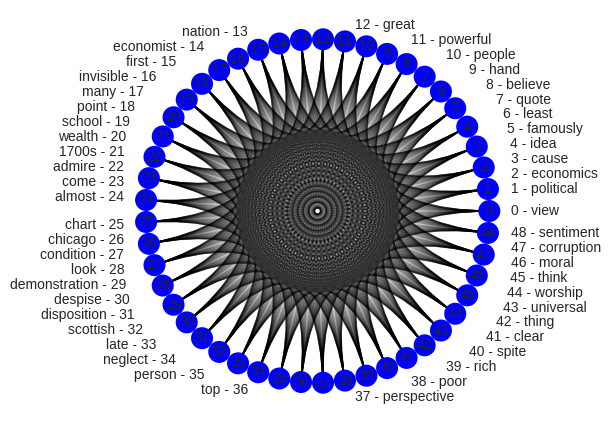

In [76]:
visualise_clique(-4)

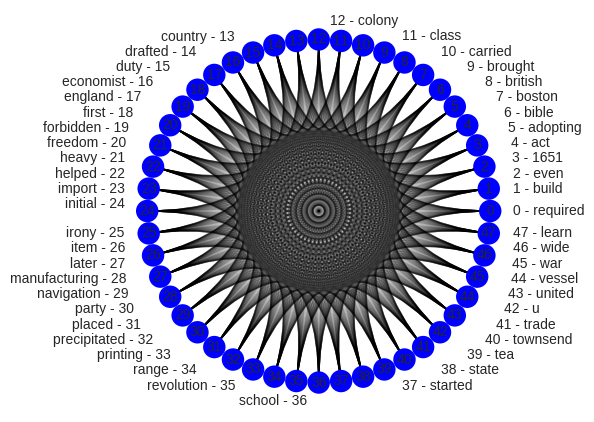

In [77]:
visualise_clique(-5)

In [78]:
def word_count_desc(corpus):
  total_word_count = collections.defaultdict(int)
  for word_id, word_count in itertools.chain.from_iterable(corpus):
      total_word_count[word_id] += word_count
  sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)
  return sorted_word_count

sorted_word_count = word_count_desc(corpus)
print(sorted_word_count[:10])

[(85, 2868), (61, 2687), (46, 2554), (69, 2448), (170, 1758), (250, 1696), (63, 1669), (183, 1414), (139, 1272), (18, 1243)]


In [79]:
for word_id, word_count in sorted_word_count[:20]:
    print(dictionary.get(word_id), word_count)

wealth 2868
free 2687
nation 2554
market 2448
people 1758
year 1696
government 1669
country 1414
cost 1272
price 1243
labor 1229
hand 1118
capitalism 1117
invisible 1071
way 1047
first 1045
great 1034
1776 1012
america 973
enterprise 962


In [80]:
def calculate_weight_of_words(corpus):
  try:
    tfidf = TfidfModel(corpus)
    all_tfidf_weights = []
    i=1
    while tfidf[corpus[i]]:
      tfidf_weights = tfidf[corpus[i]]
      sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)
      all_tfidf_weights.append(sorted_tfidf_weights)
      i+=1
    return all_tfidf_weights
  except IndexError:
    return all_tfidf_weights

all_tfidf_weights = calculate_weight_of_words(corpus)
for term_id, weight in all_tfidf_weights[1][:20]:
  print(dictionary.get(term_id), weight)

price 0.32376601254512916
true 0.2901854950398239
tax 0.23734080748050554
basic 0.22881746695409588
claim 0.22881746695409588
counting 0.22881746695409588
factory 0.22881746695409588
forget 0.22881746695409588
gas 0.22881746695409588
higher 0.22881746695409588
company 0.1835724521074739
bring 0.1791193542593157
raising 0.1791193542593157
pin 0.17827220007116645
something 0.17607756517295117
lead 0.16541190501306877
democrat 0.161399509455623
sell 0.16119656655933737
bill 0.15544573693451122
product 0.15193352796972878


In [81]:
def add_extract_length(df):
  df['Extract length'] = df['Extract'].str.len()
  return df
df = add_extract_length(df)
display(df.head())

,Extract,Notes,Notes2,About Adam Smith,Rep,Extract length
Date,,,,,,
2008-06-10,Democrats will claim this bill will bring gas ...,n/a,n/a,n/a,Mitch McConnell \nRepublican Party,356
2008-06-12,The sad truth is that the bulk of the EADS tan...,n/a,n/a,n/a,Donald Anthony Manzullo\nRepublican Party,336
2008-07-10,"The father of modern capitalism, Adam Smith, o...",n/a,n/a,n/a,Joseph Isadore Lieberman\nDemocratic Party,497
2008-07-15,This gold is not coming back on the market. Su...,n/a,n/a,n/a,Steve King\nRepublican Party,426
2008-07-23,There are those who will object to the bill be...,n/a,n/a,-‘‘The Wealth of Nations”\n- Those exertions o...,Joseph Isadore Lieberman\nDemocratic Party,475


In [82]:
def check_sentiment(df):
  polarity = []
  subjectivity = []
  for index, row in df.iterrows():
    sentiment = TextBlob(row['Extract'])
    polarity.append(sentiment.polarity)
    subjectivity.append(sentiment.subjectivity)
  df['Polarity'] = polarity
  df['Subjectivity'] = subjectivity
  return df

df_sentiments = check_sentiment(df)
display(df_sentiments.head())

,Extract,Notes,Notes2,About Adam Smith,Rep,Extract length,Polarity,Subjectivity
Date,,,,,,,,
2008-06-10,Democrats will claim this bill will bring gas ...,n/a,n/a,n/a,Mitch McConnell \nRepublican Party,356,0.140278,0.485913
2008-06-12,The sad truth is that the bulk of the EADS tan...,n/a,n/a,n/a,Donald Anthony Manzullo\nRepublican Party,336,-0.072917,0.775000
2008-07-10,"The father of modern capitalism, Adam Smith, o...",n/a,n/a,n/a,Joseph Isadore Lieberman\nDemocratic Party,497,0.250000,0.404545
2008-07-15,This gold is not coming back on the market. Su...,n/a,n/a,n/a,Steve King\nRepublican Party,426,0.005556,0.136111
2008-07-23,There are those who will object to the bill be...,n/a,n/a,-‘‘The Wealth of Nations”\n- Those exertions o...,Joseph Isadore Lieberman\nDemocratic Party,475,0.266667,0.488095


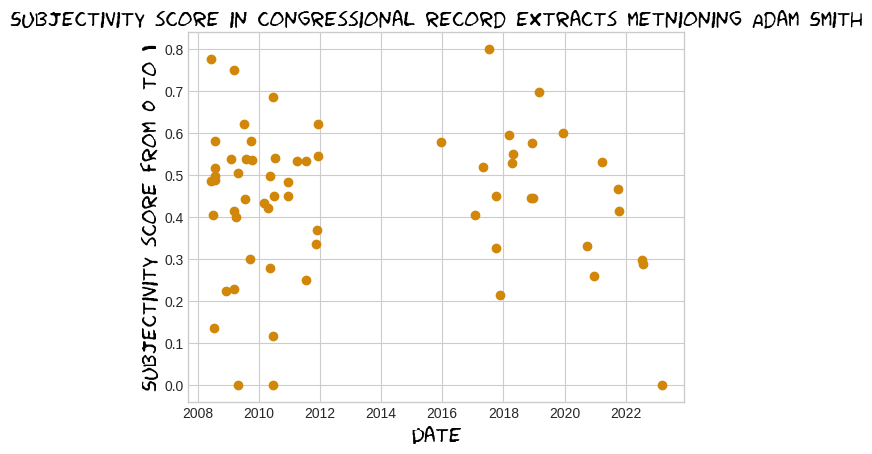

In [83]:
def plot_subjectivity_score(df):
  plt.scatter(df.index, df['Subjectivity'], color='#D1870A')
  font = {'family':'fantasy','color':'black','size':15}
  plt.ylabel('Subjectivity score from 0 to 1', fontdict = font)
  plt.xlabel('Date', fontdict = font)
  plt.title('Subjectivity score in congressional record extracts metnioning Adam Smith', fontdict = font)
  plt.show()
plot_subjectivity_score(df_sentiments)

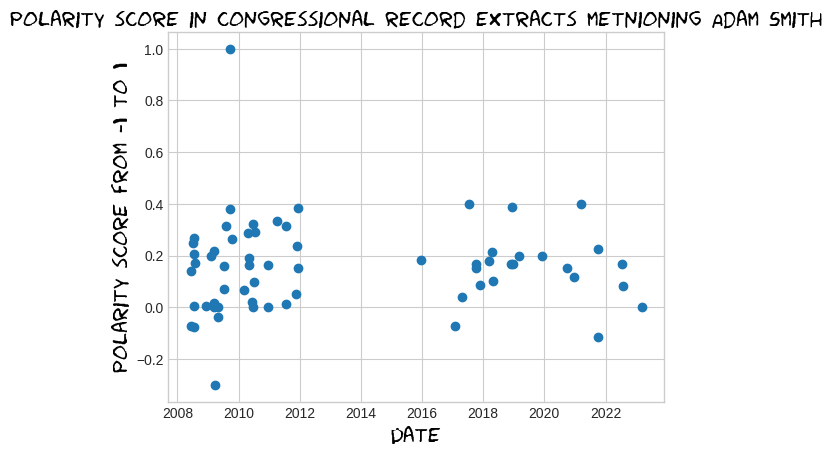

In [84]:
def plot_polarity_score(df):
  plt.scatter(df.index, df['Polarity'])
  font = {'family':'fantasy','color':'black','size':15}
  plt.ylabel('Polarity score from -1 to 1', fontdict = font)
  plt.xlabel('Date', fontdict = font)
  plt.title('Polarity score in congressional record extracts metnioning Adam Smith', fontdict = font)
  plt.show()
plot_polarity_score(df_sentiments)

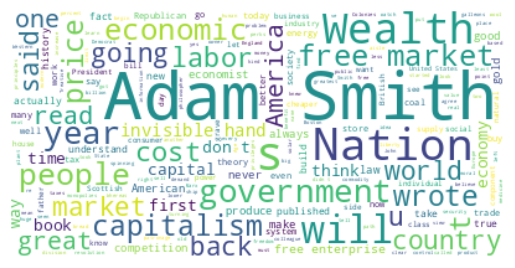

In [85]:
def word_cloud(df):
  text = " "
  for index, row in df.iterrows():
    text += " "
    text += row['Extract']
  word_cloud = WordCloud(background_color='white').generate(text)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()
word_cloud(df)

In [86]:
def bow_with_ngrams(df):
  my_stop_words = list(ENGLISH_STOP_WORDS.union(['adam', 'smith', 'speaker', 'don', 'seen', 'smith' 'wrote', 'actually', 'mr speaker', 'sure', 'said']))
  vect = CountVectorizer(ngram_range=(1, 2), max_features=200, stop_words=my_stop_words)
  vect.fit(df.Extract)
  X_extract = vect.transform(df.Extract)
  X_df=pd.DataFrame(X_extract.toarray(), columns=vect.get_feature_names_out())
  return X_df
display(bow_with_ngrams(df).columns)
bow_bigrams = bow_with_ngrams(df).head()
print(bow_bigrams)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['mr'] not in stop_words.
  warnings.warn(


Index(['1776', 'aisle', 'america', 'american', 'americans', 'based', 'believe',
       'benefits', 'better', 'big',
       ...
       'wool', 'work', 'works', 'world', 'wrote', 'wrote wealth', 'year',
       'year 1776', 'years', 'yes'],
      dtype='object', length=200)

   1776  aisle  america  american  americans  based  believe  benefits  \
0     0      0        0         0          1      0        0         0   
1     0      0        0         0          0      0        0         0   
2     0      0        0         0          0      0        0         0   
3     0      0        1         0          2      0        0         0   
4     0      0        0         0          0      0        0         0   

   better  big  ...  wool  work  works  world  wrote  wrote wealth  year  \
0       0    0  ...     0     0      0      0      0             0     0   
1       0    0  ...     0     0      0      0      0             0     0   
2       0    0  ...     0     0      0      0      0             0     0   
3       0    0  ...     0     0      0      0      1             0     0   
4       0    0  ...     0     0      0      0      1             0     0   

   year 1776  years  yes  
0          0      0    0  
1          0      0    0  
2          0     

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['mr'] not in stop_words.
  warnings.warn(
